### Author
Matya Aydin |388895

In [1]:
### Do the imports -- no need to change this
import numpy as np
from typing import List
import matplotlib.pyplot as plt
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
import sys
sys.path.insert(0, "src/")
from environment import GridWorldEnvironment
from MDPsolver import MDPsolver
from utils import *
from plot import *
%load_ext autoreload
%autoreload 2

***Before starting, we recall the use of the gridworld environment.***

The gridworld environment is instantiated via the class `GridWorldEnvironment`. 

***It takes 4 input values:***
- `reward_mode` : Integer between 0 and 3 for different reward profiles,
- `size`: Gridworld size,
- `prop`: Probability assigned to the event that the agent does not follow the chosen action but another one selected uniformely at random,
- `gamma`: Discount factor of the environment.

***Interface of a Gridworld instance:***
- `print(gridworld.n_states)` # return the number of states
- `print(gridworld.n_actions)` # return the number of actions
- `print(gridworld.r)` # return a matrix where each element indicates the reward corresponding to each (state, action) pair.
- `print(gridworld.gamma)` # return the discount factor
- `print(gridworld.sparseT[action])` # Input: action, Return: a matrix containing the state-to-state transition probabilities for the action passed as input.

<img src="../dynamic_programming/src/vis_gridworld.png" alt="fishy" class="bg-primary" width="400px">

# Ex 1: Prove of the Policy Gradient Theorem via the Performance Difference Lemma (20 points)

Denote $J(\pi) = \langle \mu, V^\pi \rangle$ and recall that the performance difference lemma states
$$
J(\pi) - J(\pi') = \mathbb{E}_{s \sim \lambda^{\pi'}}[\langle\pi(\cdot|s) - \pi'(\cdot| s) , Q^\pi(s, \cdot) \rangle]
$$
where $\lambda^{\pi'} \in \Delta_{\mathcal{S}\times\mathcal{A}}$ denotes the occupancy measure of the policy $\pi'$.

Now let us consider direct parametization, and compute a partial derivative for the entry of $\pi$ at index $(\bar{s},\bar{a})$:

$$
\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})}.
$$

**Questions**

To help you compute this partial derivative, consider the policies $\pi'$ parameterized by some (sufficiently small) $\delta \in \mathbb{R}$ via
$$
    \pi'(a|s) = \begin{cases}
        \pi(\bar{a}|\bar{s}) + \delta \quad (\text{if } (s,a)=(\bar{s},\bar{a}))\\
        \pi(a|s) \quad (\text{else})
    \end{cases}
$$

(1) Argue that
$$
\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})} =\lim_{\delta \rightarrow 0} \frac{\mathbb{E}_{s \sim \lambda^{\pi'}}[\langle\pi(\cdot|s) - \pi'(\cdot| s) , Q^\pi(s, \cdot) \rangle]}{\pi(\bar{a}|\bar{s}) - \pi'(\bar{a}|\bar{s})}.
$$

**Answer**

<font color = "blue">

Let $E_{ij} \in \mathbb{R}^{\vert \mathcal{S} \vert \times \vert \mathcal{A} \vert}$ denotes the matrix with zero entries everywhere except $E_{ij}$ = 1. By definition of derivative with respect to one entry:

$$
\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})} = \lim_{\delta \rightarrow 0} \frac{J(\pi + \delta E_{\bar{s} \bar{a}}) - J(\pi)}{\delta}
$$

Using that $\pi^{\prime}(\bar{a} \vert \bar{s}) - \pi(\bar{a} \vert \bar{s}) = \delta$ and $\pi^{\prime} - \pi = \delta E_{{\bar{s} \bar{a}}}$:

$$
\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})} = \lim_{\delta \rightarrow 0} \frac{J(\pi^{\prime}) - J(\pi)}{\pi'(\bar{a}|\bar{s}) - \pi(\bar{a}|\bar{s})} = \lim_{\delta \rightarrow 0} \frac{\mathbb{E}_{s \sim \lambda^{\pi'}}[\langle\pi(\cdot|s) - \pi'(\cdot| s) , Q^\pi(s, \cdot) \rangle]}{\pi(\bar{a}|\bar{s}) - \pi'(\bar{a}|\bar{s})}
$$

(2) Argue that $$\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})} = \lim_{\delta \rightarrow 0} \lambda^{\pi'}(\bar{s}) Q^\pi(\bar{s}, \bar{a}).$$

Hint: Write the expectation in the previous question as a sum and use the fact that $\frac{\pi(a|s) - \pi'(a|s)}{\pi(\bar{a}|\bar{s}) - \pi'(\bar{a}|\bar{s})} = \mathbf{1}_{\{ (\bar{s},\bar{a}) = (s,a) \}}$.

**Answer**

<font color = "blue">

By direct definition of the scalar product and the linearity of the expectation:

$$
\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})} =\lim_{\delta \rightarrow 0} \frac{\mathbb{E}_{s \sim \lambda^{\pi'}}[\langle\pi(\cdot|s) - \pi'(\cdot| s) , Q^\pi(s, \cdot) \rangle]}{\pi(\bar{a}|\bar{s}) - \pi'(\bar{a}|\bar{s})} = 

\lim_{\delta \rightarrow 0} \mathbb{E}_{s \sim \lambda^{\pi'}}[\sum_{a \in \mathcal{A}}\frac{\pi(a|s) - \pi'(a|s)}{\pi(\bar{a}|\bar{s}) - \pi'(\bar{a}|\bar{s})} Q^\pi(s, a)] = 

\lim_{\delta \rightarrow 0} \mathbb{E}_{s \sim \lambda^{\pi'}}[\sum_{a \in \mathcal{A}} \mathbf{1}_{\{ (\bar{s},\bar{a}) = (s,a) \}} Q^\pi(s, a)]
$$

This means that we only have one nonzero term in the sum:

$$ 
\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})} = \lim_{\delta \rightarrow 0} \mathbb{E}_{s \sim \lambda^{\pi'}}[ \mathbf{1}_{\{ (\bar{s}) = (s) \}} Q^\pi(s, \bar{a})]
$$

By definition of expectation and $\lambda^{\pi'}$:

$$
\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})} = \lim_{\delta \rightarrow 0} \sum_{s \in \mathcal{S}} (1 - \gamma) \sum_{t = 0}^{\infty} \gamma^t \mathbb{P}(s_t  =s \vert \pi^\prime) \mathbf{1}_{\{ (\bar{s}) = (s) \}} Q^\pi(s, \bar{a}) = 

\lim_{\delta \rightarrow 0} (1 - \gamma) \sum_{t = 0}^{\infty} \gamma^t \mathbb{P}(s_t  = \bar{s} \vert \pi^\prime) Q^\pi(\bar{s}, \bar{a}) = 
\lim_{\delta \rightarrow 0} \lambda^{\pi'}(\bar{s}) Q^\pi(\bar{s}, \bar{a})
$$

(3) Conclude that $$\frac{\partial J(\pi)}{\partial \pi(\bar{a}|\bar{s})} = \lambda^{\pi}(\bar{s}) Q^\pi(\bar{s}, \bar{a})$$
for the direct parameterization. 

**Answer**

<font color = "blue">

This is a direct application of the definition of $\pi^\prime$ and letting $\delta$ tends to $0$.

(4) Prove that for a general parameterization, it holds that
$$
\nabla_\theta J(\pi_\theta) = \sum_{\bar{s},\bar{a}} \lambda^{\pi}(\bar{s}, \bar{a}) Q^\pi(\bar{s}, \bar{a}) \nabla_{\theta} ( \log \pi_\theta(\bar{a}|\bar{s}))
$$

Hint: Use the chain rule to write $$ \nabla_\theta J(\pi_\theta)  = \sum_{\bar{s},\bar{a}} \frac{\partial J(\pi)}{\partial \pi_\theta(\bar{a}|\bar{s})} \nabla_{\theta} \pi_\theta(\bar{a}|\bar{s}), $$
and then use the fact that $\lambda^{\pi}(\bar{s},\bar{a}) = \lambda^{\pi}(\bar{s}) \pi(\bar{a}|\bar{s})$.

**Answer**

<font color  = "blue">



By the chain rule:

$$
\nabla_\theta J(\pi_\theta)  = \frac{\partial J}{\partial \pi} \frac{\partial \pi}{ \partial \theta} =  \sum_{\bar{s},\bar{a}} \frac{\partial J(\pi)}{\partial \pi_\theta(\bar{a}|\bar{s})} \nabla_{\theta} \pi_\theta(\bar{a}|\bar{s})
$$

By definition of $\log$:

$$
\nabla_{\theta} ( \log \pi_\theta(\bar{a}|\bar{s})) = \frac{\nabla_{\theta} \pi_\theta(\bar{a}|\bar{s})}{\pi_\theta(\bar{a}|\bar{s})} \iff
\nabla_{\theta} \pi_\theta(\bar{a}|\bar{s}) = \pi_\theta(\bar{a}|\bar{s}) \nabla_{\theta} ( \log \pi_\theta(\bar{a}|\bar{s}))
$$

Using this relation, the result derived above and finally the fact that $\lambda^{\pi}(\bar{s},\bar{a}) = \lambda^{\pi}(\bar{s}) \pi(\bar{a}|\bar{s})$:

$$
\nabla_\theta J(\pi_\theta)  = \sum_{\bar{s},\bar{a}} \frac{\partial J(\pi)}{\partial \pi_\theta(\bar{a}|\bar{s})} \pi_\theta(\bar{a}|\bar{s}) \nabla_{\theta} ( \log \pi_\theta(\bar{a}|\bar{s})) = 

\sum_{\bar{s},\bar{a}} \lambda^{\pi_\theta}(\bar{s})  Q^{\pi_{\theta}}(\bar{s}, \bar{a}) \pi_\theta(\bar{a}|\bar{s}) \nabla_{\theta} ( \log \pi_\theta(\bar{a}|\bar{s})) = 
\sum_{\bar{s},\bar{a}} \lambda^{\pi_{\theta}}(\bar{s}, \bar{a}) Q^{\pi_\theta}(\bar{s}, \bar{a}) \nabla_{\theta} ( \log \pi_\theta(\bar{a}|\bar{s}))

$$

# Ex 2: Natural Policy Gradient with softmax parameterization (20 points)

Recall that the iterates $\{\pi^t\}^{\infty}_{t=1}$ produced by NPG read as follows:
$$
\pi^{t+1}(a|s) = \frac{\pi^t(a|s)e^{\eta Q^{\pi^t}(s,a) }}{\sum_{a'} \pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')}}.
$$

**Question** 

Implement NPG for an arbitrary step size $\eta$.

In [2]:
def evaluate_policy(pi, env, tol=1e-10):
    """Implementation of policy evaluation through iteratively applying using a certain policy 
    Args:
        pi: a policy stochastic passed with shape n_states times n_actions
        env: environment
        tol: a scalar to dermerminate whether the policy evaluation convergences
    Returns:
        v: an array with the values of the actions chosen
        q: an array with the q values    
    """
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    while True:
        v_old = np.copy(v)
        for a in range(env.n_actions):
            q[:, a] = env.r[:, a] + env.gamma * env.sparseT[a].dot(v)
        for s in range(env.n_states):
            v[s] = q[s].dot(pi[s])
        if np.linalg.norm(v - v_old) < tol:
            break
    return v, q

def npg_update(q, eta, old_policy):
    """Implementation of a greedy approach to choose policies (policy improvement)
    Args:
        q: q values obtained from evaluating the policies
    Returns:
        new_policy: the updates policy
    """

    eps = 1e-10
    policy = np.zeros_like(q)
    for s in range(q.shape[0]):
        policy[s] = old_policy[s] * np.exp(eta * q[s])
        factor = np.sum(policy[s])
        if factor < eps:
            #if the policy is zero, we set it to be uniform
            policy[s] = 1 / q.shape[1]
        else:
            policy[s] /= factor 
    return policy

def get_greedy_policy(q):
    """Implementation of a greedy approach to choose policies (policy improvement)
    Args:
        q: q values obtained from evaluating the policies
    Returns:
        policy: greedy policy (list)
    """
    policy = np.zeros_like(q)
    for s in range(q.shape[0]):
        policy[s,np.argmax(q[s,:])] = 1
    return policy

In [3]:
def NPG(env, eta): # apply NPG iterations for 30 steps
    vs = []
    policies = []
    v = np.zeros(env.n_states)
    q = np.zeros((env.n_states, env.n_actions))
    pi = np.ones_like(q)/env.n_actions
    for k in range(30):
        v_old = np.copy(v)
        v, q = evaluate_policy(pi, env)
        if eta < np.inf:
            pi = npg_update(q, eta, pi)
        else:
            pi = get_greedy_policy(q)
        vs.append(v)
        policies.append(pi)
    return vs, policies

Now, we run NPG for different stepsizes in the usual gridworld environment

In [4]:
reward_mode = 2
size = 10 
prop = 0
gamma=0.99
gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)
mu = np.ones(gridworld.n_states)/gridworld.n_states
etas = [1e-3, 1e-2, 1e-1, 1, 100, 1e7, np.inf]
v_different_etas = []
pi_different_etas = []
for eta in etas:
    print(f"eta: {eta}")
    values_pi, policies = NPG(gridworld, eta=eta)
    v_different_etas.append(values_pi)
    pi_different_etas.append(policies)
    

eta: 0.001
eta: 0.01
eta: 0.1
eta: 1
eta: 100
eta: 10000000.0
eta: inf


In [5]:
solver = MDPsolver(gridworld)
solver.value_iteration()

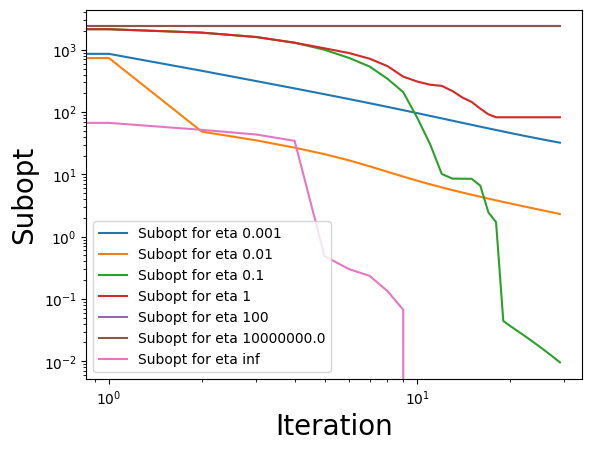

In [6]:
# TODO: if this plot appears with a too large legend, rerun this line once more
plot_log_lines([np.array([mu.dot(solver.v - v) for v in v_different_etas[i]]) for i, _ in enumerate(etas)], [f"Subopt for eta {eta}" for eta in etas], ["Iteration", "Subopt"], "figs", "NPG.pdf", show = True)

**Question**

Show that NPG with $\eta = \infty$ coincides with Policy Iteration (PI).

More formally: Assuming that $a^\star_s := \mathrm{argmax}_a Q^{\pi^t}(s,a)$ is unique for all $s$, prove that $$ \lim_{\eta \rightarrow \infty} \frac{\pi^t(a|s)e^{\eta Q^{\pi^t}(s,a) }}{\sum_{a'} \pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')}} = \begin{cases} 1 \quad \text{if} \quad a = a^\star_s \\ 0 \quad \text{otherwise} \end{cases},$$
and explain how this relates to PI.

**Answer**

<font color = "blue">

First, recall the policy improvement step of the policy iteration algorithm:
$$
\pi_{t+1}(s) = \argmax_{a \in \mathcal{A}} Q^{\pi_t}(s, a)
$$

We can multiply the limit by $\frac{e^{\eta Q^{\pi_t}(s,a^\star_s)}}{e^{\eta Q^{\pi_t}(s,a^\star_s)}}$:

$$
\lim_{\eta \rightarrow \infty} \frac{\pi^t(a|s)e^{\eta Q^{\pi^t}(s,a) }}{\sum_{a'} \pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')}} \frac{e^{\eta Q^{\pi_t}(s,a^\star_s)}}{e^{\eta Q^{\pi_t}(s,a^\star_s)}} =
\lim_{\eta \rightarrow \infty} \frac{\pi^t(a|s)e^{\eta ( Q^{\pi^t}(s,a) - Q^{\pi^t}(s,a^\star_s)) }}{\sum_{a'} \pi^t(a'|s) e^{\eta ( Q^{\pi^t}(s,a') - Q^{\pi^t}(s,a^\star_s))}} 
$$


By definition of $\argmax$, $Q^{\pi^t}(s,a) - Q^{\pi^t}(s,a^\star_s) \le 0$ and $Q^{\pi^t}(s,a) - Q^{\pi^t}(s,a^\star_s) = 0$ if and only if $a = a^\star_s$. because $a^\star_s$ is unique.  Consequently:

$$
\lim_{\eta \rightarrow \infty} e^{\eta ( Q^{\pi^t}(s,a) - Q^{\pi^t}(s,a^\star_s)) }  = \begin{cases} 1 \quad \text{if} \quad a = a^\star_s \\ 0 \quad \text{otherwise} \end{cases}
$$

The same result follows for the whole limit:

$$
\lim_{\eta \rightarrow \infty} \frac{\pi^t(a|s)e^{\eta Q^{\pi^t}(s,a) }}{\sum_{a'} \pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')}} = \lim_{\eta \rightarrow \infty} \frac{\pi^t(a|s)e^{\eta Q^{\pi^t}(s,a) }}{\pi^t(a^\star_s|s) e^{\eta Q^{\pi^t}(s, a^\star_s)}} = \begin{cases} 1 \quad \text{if} \quad a = a^\star_s \\ 0 \quad \text{otherwise} \end{cases}
$$

Namely, at each step, we only keep the argmax with respect to the actions, which is the same update as the PI algorithm.

**Question**

Is this observation in line with the empirical results in the plot above? I.e., is the plot for $\eta = \infty$ as you would expect it for PI?

**Answer**

<font color="blue">

In homework 1, we had the following plot for policy iteration:

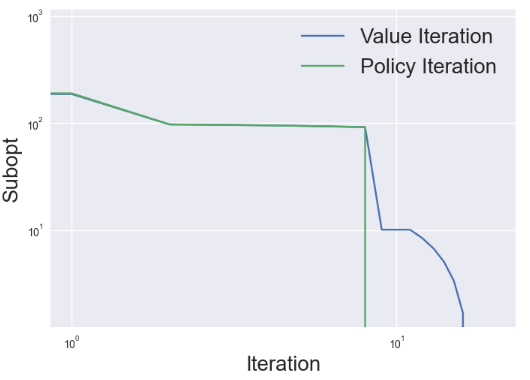


We can see that the graphs slightly coincide, both in term of shape and values with respect to all iterations: low variation during the first iterations before diving at the $9^{th}$ iteration.

# Ex 2.1 Slow Changing Property of NPG

In this exercise you will investigate by how much consecutive iterates $\pi^t$ and $\pi^{t+1}$ produced by NPG differ and how this distance is controlled by the step size $\eta$.

Plot $$\max_{s \in \mathcal{S}} || \pi^{t+1}(a|s) - \pi^t(a|s) ||_1$$ for different values of $\eta$.

In [7]:
def compute_policy_variation(policies):
    variation = []
    for pi, pip in zip(policies[1:], policies[:-1]):
        variation.append(np.max([ np.linalg.norm(pi[s] - pip[s], 1) for s in range(pi.shape[0])])) # TODO
    return variation

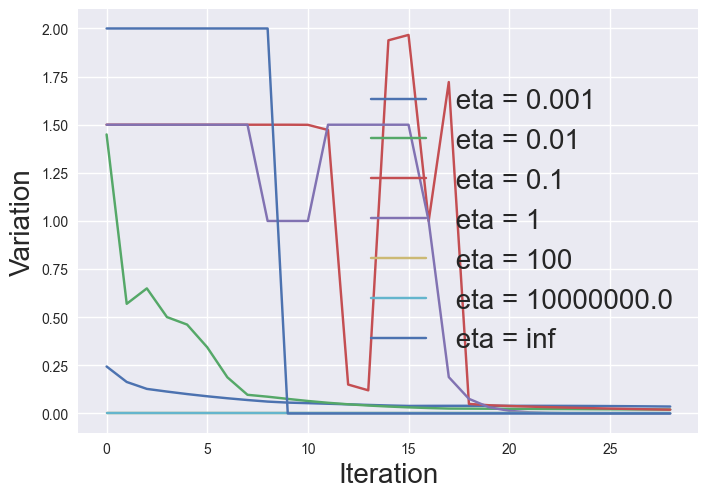

In [8]:
plot_lines(np.array([ compute_policy_variation(np.array(pi_different_etas)[i])
                           for i, _ in enumerate(etas)]), 
               [f" eta = {eta}" for eta in etas], 
               ["Iteration", "Variation"], "figs", "NPG.pdf", show = True)

**Question**

Empirically, is the largest change (among all iterations) between consecutive iterations is larger for smaller or large values of $\eta$?

<font color = "blue">

The largest change between two consecutive iterations occurs for $\eta = \infty$, this can be explained using the bound provided in the next exercise:

$$ || \pi^{t+1}(\cdot|s) - \pi^t(\cdot|s) ||_1 \leq \frac{\eta}{1 - \gamma} \quad \forall s \in \mathcal{S}, \forall t \in [T].$$

If $\eta$ is large, $\vert \pi^{t+1}(\cdot|s) - \pi^t(\cdot|s) \vert$ can be large for some $t$. If $\eta$ is small, all $\vert \pi^{t+1}(\cdot|s) - \pi^t(\cdot|s) \vert$ are small $\forall t$.




## Some Theory to Motivate the Observation Above

**Question**

Our goal is to prove that $$ || \pi^{t+1}(\cdot|s) - \pi^t(\cdot|s) ||_1 \leq \frac{\eta}{1 - \gamma} \quad \forall s \in \mathcal{S}, \forall t \in [T].$$

We guide you towards this result by breaking the proof into small steps.

1) Prove that $$ \frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \leq \mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)] - \log \bigg(\sum_{a'\in\mathcal{A}} \pi^t(a'|s) \exp (\eta Q^{\pi^t}(s,a'))\bigg) $$

Hint: First apply Pinkser's inequality https://en.wikipedia.org/wiki/Pinsker%27s_inequality to prove that $$\frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \leq KL(\pi^{t+1}(s)||\pi^t(s)), $$ then plug in the formula for $\pi^{t+1}$ into the KL term.

**Answer**

<font color = "blue">

Using Pinkser's inequality and the definition of supremum, $\forall s \in \mathcal{S}$:

$$
\frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \le 2 \sup_{s \in \mathcal{S}} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \le KL(\pi^{t+1}(s)||\pi^t(s))
$$

With 

$$
KL(\pi^{t+1}(s)||\pi^t(s)) = \sum_{a \in \mathcal{A}} \pi^{t+1}(s) \log(\frac{\pi^{t+1}(s)}{\pi^{t}(s)}) =
 \sum_{a \in \mathcal{A}} \frac{\pi^t(a|s)e^{\eta Q^{\pi^t}(s,a) }}{\sum_{a'} \pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')}} \log(\frac{e^{\eta Q^{\pi^t}(s,a) }}{\sum_{a'} \pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')}})
$$

By properties of the log:

$$
\sum_{a \in \mathcal{A}} \frac{\pi^t(a|s)e^{\eta Q^{\pi^t}(s,a) }}{\sum_{a'} \pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')}} \log(\frac{e^{\eta Q^{\pi^t}(s,a) }}{\sum_{a'} \pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')}}) = \sum_{a \in \mathcal{A}} \frac{\pi^t(a|s)e^{\eta Q^{\pi^t}(s,a) }}{\sum_{a'} \pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')}} [\eta Q^{\pi^t}(s,a) - \log(\sum_{a'} \pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')})]
$$

By definition of expectation:

$$
\sum_{a \in \mathcal{A}} \frac{\pi^t(a|s)e^{\eta Q^{\pi^t}(s,a) }}{\sum_{a'} \pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')}} [\eta Q^{\pi^t}(s,a) - \log(\sum_{a'} \pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')})] = \mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)] - \log(\sum_{a'} \pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')})
$$

Where we used the fact that the second term is equal to its expectation (it does not depend on $a$). This allows us to conlude that
$$
\frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \leq \mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)] - \log \bigg(\sum_{a'\in\mathcal{A}} \pi^t(a'|s) \exp (\eta Q^{\pi^t}(s,a'))\bigg)
$$


2) Prove that 
$$
\sum_{a\in \mathcal{A}} \pi^{t+1}(a|s) \exp(- \eta Q^{\pi^t}(s,a)) = \frac{1}{\sum_{a'\in \mathcal{A}} \pi^t(a|s) \exp(\eta Q^{\pi^t}(s,a) )}.
$$

**Answer**

<font color = "blue">

$$
\sum_{a\in \mathcal{A}} \pi^{t+1}(a|s) \exp(- \eta Q^{\pi^t}(s,a)) =

 \sum_{a\in \mathcal{A}} \frac{\pi^t(a|s)e^{\eta Q^{\pi^t}(s,a) }}{\sum_{a'} \pi^t(a'|s) e^{\eta Q^{\pi^t}(s,a')}} \exp(- \eta Q^{\pi^t}(s,a)) = \frac{1}{\sum_{a'\in \mathcal{A}} \pi^t(a'|s) \exp(\eta Q^{\pi^t}(s,a') )}
$$

Where we used that $\sum_{a \in \mathcal{A}} \pi^t(a|s) = 1$ because each step of NPG normalises the policy with respect to the action ($\pi(. \vert s)$ is a probability distribution).

3) Using the results in 1) and 2) prove that 

$$ \frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \leq \mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)] + \log \bigg(\sum_{a'\in\mathcal{A}} \pi^{t+1}(a'|s) \exp (-\eta Q^{\pi^t}(s,a'))\bigg). $$

**Answer**

<font color = "blue">

Using 2):

$$
- \log \bigg(\sum_{a'\in\mathcal{A}} \pi^t(a'|s) \exp (\eta Q^{\pi^t}(s,a'))\bigg) = \log(\frac{1}{\sum_{a'\in\mathcal{A}} \pi^t(a'|s) \exp (\eta Q^{\pi^t}(s,a'))}) = \log(\sum_{a\in \mathcal{A}} \pi^{t+1}(a|s) \exp(- \eta Q^{\pi^t}(s,a)))
$$

By plotting this into 1), we directly get:

$$ \frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \leq \mathbb{E}_{a \sim \pi^{t+1}(\cdot|s)}[\eta Q^{\pi^t}(s,a)] + \log \bigg(\sum_{a'\in\mathcal{A}} \pi^{t+1}(a'|s) \exp (-\eta Q^{\pi^t}(s,a'))\bigg)$$


4) Using Hoeffding's Lemma https://en.wikipedia.org/wiki/Hoeffding%27s_lemma (on the sum in the log term!) and the fact that $$-\frac{1}{1-\gamma} \leq Q^{\pi^t}(s,a) \leq \frac{1}{1-\gamma},$$ conclude that 
$$\frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \leq \frac{\eta^2}{2 (1 - \gamma)^2}.$$

<font color = "blue">

First, notice that
$$
\log \bigg(\sum_{a'\in\mathcal{A}} \pi^{t+1}(a'|s) \exp (-\eta Q^{\pi^t}(s,a'))\bigg) = \log(\mathbb{E}_{a' \sim \pi^{t+1}(\cdot|s)}[\exp (-\eta Q^{\pi^t}(s,a'))])
$$
Then by monotonicity of the log and by Hoeffding's Lemma, we get:
$$
\log(\mathbb{E}_{a' \sim \pi^{t+1}(\cdot|s)}[\exp (-\eta Q^{\pi^t}(s,a'))]) \le \log(\exp(- \eta \mathbb{E}_{a' \sim \pi^{t+1}(\cdot|s)}[Q^{\pi^t}(s,a')] + \frac{\eta^2}{2 (1 - \gamma)^2})) = - \eta \mathbb{E}_{a' \sim \pi^{t+1}(\cdot|s)}[Q^{\pi^t}(s,a')] + \frac{\eta^2}{2 (1 - \gamma)^2}
$$

By plugging this into the bound derived in 3), we directly get $$\frac{1}{2} || \pi^{t+1}(s) - \pi^t(s) ||^2_1 \leq \frac{\eta^2}{2 (1 - \gamma)^2}.$$

# Ex 3: OPPO: The importance of Exploration in Policy Gradient (20 points)

In this exercise, we will investigate how crucial it is to perform exploration. That is, adding bonuses to avoid suffering the mismatch coefficients in the convergence bounds.

Let us recall that the standard sample based version of NPG suffers the mismatch coeffcients in the bounds (see Slide 22 in Lecture 5). Those are avoided by OPPO ( See slide 30 in Lecture 5 ).

**To see clearly the advatange of OPPO we will consider an MDP with unbounded mismatch coefficients**

**Question: example of unbounded mismatch coefficients**

Consider a 10 x 10 gridworld, the initial state is always the bottom right corner, i.e. the initial distribution $\mu$ equals $1$ at this starting state and it is zero everywhere else. Can you compute a finite bound for 
$$\max_\pi \max_{s \in \mathcal{S}} \bigg |\frac{\lambda^\pi(s)}{\mu(s)} \bigg|,$$
i.e. the mismatch coefficient? If not, argue for which reason.

**Answer**



<font color = "blue">


Clearly, $\max_{s \in \mathcal{S}}$ will select a state $s^\star$ different than $s_0$, so that $\mu(s^\star) = 0$. The problem becomes:

$$
\max_{\pi} \frac{\lambda^\pi(s^\star)}{\mu(s^\star)}
$$

For any nontrivial policy $\pi$ that ends up assigning a non-zero probability to $s^\star$, $\lambda^\pi(s^\star)$ will be nonzero and $\max_\pi \max_{s \in \mathcal{S}} \bigg |\frac{\lambda^\pi(s)}{\mu(s)} \bigg|,$ will be unbounded thus we cannot compute a finite bound.

In the following, we experiment with OPPO with and without bonuses in this environment.

In [9]:
reward_mode = 0
size = 10
gamma=0.999
gridworld = GridWorldEnvironment(reward_mode, size, prop=0, gamma=gamma)
r_max = np.max(gridworld.r)
r_min = np.min(gridworld.r)
gridworld.r = (gridworld.r - r_min) / (r_max - r_min)

In [10]:
from copy import deepcopy
def oppo(K: int = 10000, H: int = 20, beta: float = 0.0001, eta=10000) -> List[float]:
    """
    Function implementing OPPO with UCB bonuses algorithm.

    :param K: Number of episodes, positive int
    :param H: Number of steps per episode, positive int
    :param beta: Algorithm hyperparameter, constant which scales the bonuses, positive float

    :return: reward after each step, list of K * H floats
    """

    # Initialize tabular records
    rewards = []
    Q = H * np.ones((H, gridworld.n_states, gridworld.n_actions))
    V = H * np.ones((H + 1, gridworld.n_states))
    policy = H * np.ones((H, gridworld.n_states, gridworld.n_actions))/gridworld.n_actions
    V[H, :] = 0
    estimated_transitions = np.ones((H, gridworld.n_states, 
                                     gridworld.n_actions, 
                                     gridworld.n_states))/gridworld.n_states
    N = np.zeros((H, gridworld.n_states, gridworld.n_actions))
    bonus = np.zeros((H, gridworld.n_states, gridworld.n_actions))
    N_next = np.zeros((H, gridworld.n_states, gridworld.n_actions, gridworld.n_states)) #Nh in slides

    for k in range(K):  # Episode loop
        if k % 1000 == 0:
            print(k, "k")
        state = 99  # Initial state
        for h in range(H):
            #NPG Update

            #subtract the maximum Q value from the Q values to avoid overflow
            policy[h, state, :] *= np.exp(eta * (Q[h, state, :] - np.max(Q[h, state, :]))) + 1e-10 # TODO (unnormalized)
            # Normalize the policy
            policy[h, state, :] /= np.sum(policy[h, state, :]) # TODO: normalize
            # Sample one action the current policy
            a = np.random.choice(gridworld.n_actions, p=policy[h, state,:]) # TODO
            rewards.append(gridworld.r[state, a])

            # Record that we visited this state-action pair (again)
            N[h, state, a] += 1 # TODO

            # Get the new state according to the transition dynamics
            new_state = np.random.choice(gridworld.n_states,
                                         p=gridworld.T[a][state])
            N_next[h, state, a, new_state] += 1 # TODO
            
            estimated_transitions[h,state,a, :] =  N_next[h, state, a, :] / (N[h, state, a] + 1)# TODO
            

            # Calculate the UCB bonus
            state = new_state
        
        bonus = beta * np.sqrt(H**3 / (N+1)) #Should be of dimension H x Sx A
        Q_new = np.zeros_like(Q)
        V_new = np.zeros_like(V)
        for h in reversed(range(H)):  # Step loop
            # Update Q according to the algorithm
            Q_new[h] = gridworld.r + bonus[h] + np.dot(estimated_transitions[h], V_new[h+1]) # TODO
            #clip
            Q_new[h] = np.clip(Q_new[h], 0, H - h)

            # Update V as the Q-value of the optimal actions for the current state
            for state in range(gridworld.n_states):
                V_new[h, state] = np.max(Q_new[h, state]) # TODO
        Q = deepcopy(Q_new)
        V = deepcopy(V_new)
    return rewards

In [11]:
to_plot = []
betas = [0, 1e-5, 1e-4, 1e-3, 1e-1]

for beta in betas:
    reward_OPPO = oppo(beta = beta)  # You can play around with the arguments if you like
    to_plot.append(np.cumsum(reward_OPPO))

0 k
1000 k
2000 k
3000 k
4000 k
5000 k
6000 k
7000 k
8000 k
9000 k
0 k
1000 k
2000 k
3000 k
4000 k
5000 k
6000 k
7000 k
8000 k
9000 k
0 k
1000 k
2000 k
3000 k
4000 k
5000 k
6000 k
7000 k
8000 k
9000 k
0 k
1000 k
2000 k
3000 k
4000 k
5000 k
6000 k
7000 k
8000 k
9000 k
0 k
1000 k
2000 k
3000 k
4000 k
5000 k
6000 k
7000 k
8000 k
9000 k


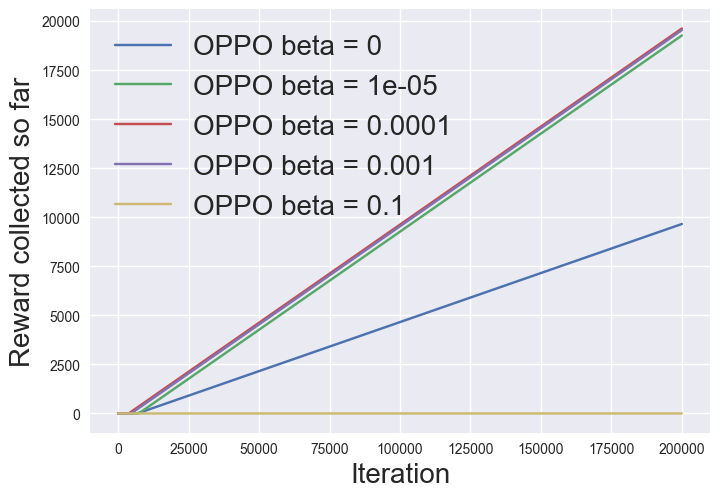

In [12]:
labels = [ f"OPPO beta = {beta}" for beta in betas]
plot_lines(
    to_plot,
    labels,
    ["Iteration", "Reward collected so far"],
    "figs",
    "ucbvseps",
    show=True
)

**Question**

Why does setting $\beta = 0$ lead to bad results? 

*Hint: Explain using the remarks in slide 28 and the theoretical bound in Slide 22 of Lecture 5*.

**Answer**


<font color = "blue">

From slide 28:
If it holds that 
$$
\vert \sum_{s \prime}\hat{P}_h(s \prime \mid s, a) - P_h(s \prime \mid s, a) V(s') \vert \leq \text{bonus}_h(s, a)
$$
then Optimism
and Bounded Optimism hold.

If $\beta = 0$, the bonus is also equals to 0. this means that optimism and bounded optimism does not hold and that the convergence rate depends on $\kappa$, which can be large. Intuitively, this means that exploration is not enhanced.

**Question**

Why does setting $\beta$ too large lead to poor results?

*Hint: Answer using the regret bound for OPPO given at the beginning of slide 30.*

**Answer**

<font color = "blue">


The regret bound for OPPO is:

$$

\sum_{t=1}^T V^\star(s_1) - V^{\pi^t}(s_1) \leq \mathcal{O} \left( \sum_{h=1}^H \sum_{t=1}^T \text{bonus}_h^t(s_h^t, a_h^t) \right)
$$

the larger $\beta$ is, the larger the bonus is, which means that the suboptimality can be bigger because the upper bound is bigger. Intuitively, this is because we overestimate $Q$ in the less commonly visited states that could be suboptimal, leading to over-exploration in states that are not interesting.


# Ex 4: REINFORCE with parametrized policies (20 points)

In this exercise, we will investigate the effect of choosing different baselines in the reinforce implementation.
This topic is covered from Slide 31 on in Lecture 5.

**Hint: You may want to use Google Colab to run the experiments faster, but you don't have to.**

### Import the Necessary Packages

In [13]:
# TODO: you may need to run this to make sure to have the correct versions
!pip install gym==0.25.2
!pip install gym-notices==0.0.8

In [14]:
import gym
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (16, 10)

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
torch.manual_seed(0)

import base64, io

# For visualization
from gym.wrappers.monitoring import video_recorder
from IPython.display import HTML
from IPython import display
import glob

In [15]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

### Instantiate the Environment and Agent

The CartPole environment is very simple. It has discrete action space (2) and 4 dimensional state space.

In [16]:
env = gym.make('CartPole-v0')
env.seed(0)

C:\Users\matya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
C:\Users\matya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\matya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_ste

[0]

In [17]:
class Policy(nn.Module): # define the policy network
    def __init__(self, state_size=4, action_size=2, hidden_size=32):
        super(Policy, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, action_size)

    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = self.fc2(x)
        return F.softmax(x, dim=1) # we just consider 1 dimensional probability of action (the force to push the cart to the left or right)

    def act(self, state):
        state = torch.from_numpy(state).float().unsqueeze(0).to(device)
        probs = self.forward(state).cpu()
        model = Categorical(probs)
        action = model.sample()
        return action.item(), model.log_prob(action)
    

In [18]:
# REINFORCE (with reward-to-go)
# --> with gradient estimator according to version 2 of the PG theorem (not using Q-values, but reward to go)
def reinforce_rwd2go(policy, optimizer, early_stop=False, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        state = env.reset() #reset to new initial state
        # Collect trajectory
        for t in range(max_t): 
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action) #executes the action determined by the policy, which gives a reward
            rewards.append(reward)
            if done: #we enter a terminal state
                break
        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        #J(pi)
        rewards_to_go = [sum([discounts[j]*rewards[j+t] for j in range(len(rewards)-t) ]) for t in range(len(rewards))]

        # Calculate the loss
        policy_loss = []
        for i in range(len(saved_log_probs)):
            log_prob = saved_log_probs[i]
            G = rewards_to_go[i]
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            #weights loss by the log probability of the action taken
            policy_loss.append(-log_prob * G)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()

        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
        if early_stop and np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
    return scores

**Question**

1. Find **two** good baselines that improve over the implementation of REINFORCE without baseline. You should plot their results below.

You can take inspiration from the Example Notebook we attached for lecture 4, but you **cannot use exactly the same**.

2. Explain why you chose your baselines and why you think they are reasonable.

*Note:* You may also change other parameters such as the learning rate, as long as you clearly state it in your response.

**Answer**

<font color = "blue">

**TODO**


In [ ]:
def naive_baseline(state): # Example Baseline from lecture 4 (for inspiration)
  angle = state[2]
  value = 100*(0.25-angle**2) # TO BE CHANGED USING YOUR BASELINE
  return value

def baseline_1(state): # TO BE CHANGED USING YOUR BASELINE 1
  # TODO
  position = state[0]
  velocity = state[1]
  return position**2 # TODO

def baseline_2(state): # TO BE CHANGED USING YOUR BASELINE 2
    # TODO
  return 0 # TODO

# PLOT 3: reward-to-go with baseline REINFORCE
# --> with gradient estimator according to version 3 of the PG theorem (not using Q-values, but reward to go)
# --> here, we consider only fixed (handcrafted) baseline functions b : S -> R; clearly, training a NN to predict V^{\pi}(s) as a baseline is also possible (and interesting!)
def reinforce_rwd2go_baseline(policy, optimizer, early_stop=False, baseline=naive_baseline, n_episodes=1000, max_t=1000, gamma=1.0, print_every=100):
    scores_deque = deque(maxlen=100)
    scores = []
    for e in range(1, n_episodes):
        saved_log_probs = []
        rewards = []
        baseline_values = []
        state = env.reset()
        # Collect trajectory
        for t in range(max_t):
            # Sample the action from current policy
            action, log_prob = policy.act(state)
            saved_log_probs.append(log_prob)
            state, reward, done, _ = env.step(action)
            rewards.append(reward)
            baseline_values.append(baseline(state))
            if done:
                break
        # Calculate total expected reward
        scores_deque.append(sum(rewards))
        scores.append(sum(rewards))

        # Recalculate the total reward applying discounted factor
        discounts = [gamma ** i for i in range(len(rewards) + 1)]
        rewards_to_go = [sum([discounts[j]*rewards[j+t] for j in range(len(rewards)-t) ]) for t in range(len(rewards))]

        # Calculate the loss
        policy_loss = []
        for i in range(len(saved_log_probs)):
            log_prob = saved_log_probs[i]
            G_centered = rewards_to_go[i] - baseline_values[i]
            # Note that we are using Gradient Ascent, not Descent. So we need to calculate it with negative rewards.
            policy_loss.append(-log_prob * G_centered)
        # After that, we concatenate whole policy loss in 0th dimension
        policy_loss = torch.cat(policy_loss).sum()

        # Backpropagation
        optimizer.zero_grad()
        policy_loss.backward()
        optimizer.step()

        if e % print_every == 0:
            print('Episode {}\tAverage Score: {:.2f}'.format(e, np.mean(scores_deque)))
        if early_stop and np.mean(scores_deque) >= 195.0:
            print('Environment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(e - 100, np.mean(scores_deque)))
            break
    return scores

In [20]:
env = gym.make('CartPole-v0')
env.seed(0)

# PLOT 1: run REINFORCE
policy_rwd2go = Policy().to(device)
optimizer_rwd2go = optim.Adam(policy_rwd2go.parameters(), lr=1e-2)
scores_rwd2go = reinforce_rwd2go(policy_rwd2go, optimizer_rwd2go, early_stop=False, n_episodes=2000)

env = gym.make('CartPole-v0')
env.seed(0)
# PLOT 2: run REINFORCE and YOUR baseline 1
policy_baseline_1 = Policy().to(device)
optimizer_baseline_1 = optim.Adam(policy_baseline_1.parameters(), lr=1e-2)
scores_baseline_1 = reinforce_rwd2go_baseline(policy_baseline_1, optimizer_baseline_1, baseline=baseline_1, early_stop=False, n_episodes=2000)

"""
env = gym.make('CartPole-v0')
env.seed(0)
# PLOT 3: run REINFORCE and YOUR baseline 2
policy_baseline_2 = Policy().to(device)
optimizer_baseline_2 = optim.Adam(policy_baseline_2.parameters(), lr=1e-2)
scores_baseline_2 = reinforce_rwd2go_baseline(policy_baseline_2, optimizer_baseline_2, baseline=baseline_2, early_stop=False, n_episodes=2000)
"""


C:\Users\matya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\utils\passive_env_checker.py:241: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


Episode 100	Average Score: 47.39
Episode 200	Average Score: 131.06
Episode 300	Average Score: 155.38
Episode 400	Average Score: 194.95
Episode 500	Average Score: 158.26
Episode 600	Average Score: 106.31
Episode 700	Average Score: 193.25
Episode 800	Average Score: 200.00
Episode 900	Average Score: 200.00
Episode 1000	Average Score: 200.00
Episode 1100	Average Score: 200.00
Episode 1200	Average Score: 193.75
Episode 1300	Average Score: 185.61
Episode 1400	Average Score: 190.57
Episode 1500	Average Score: 198.55
Episode 1600	Average Score: 159.00
Episode 1700	Average Score: 183.87
Episode 1800	Average Score: 191.85
Episode 1900	Average Score: 103.99


C:\Users\matya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\envs\registration.py:593: UserWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.warn(
C:\Users\matya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
C:\Users\matya\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\gym\wrappers\step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_ste

Episode 100	Average Score: 48.13
Episode 200	Average Score: 142.08
Episode 300	Average Score: 190.94
Episode 400	Average Score: 189.04
Episode 500	Average Score: 190.74
Episode 600	Average Score: 198.74
Episode 700	Average Score: 192.69
Episode 800	Average Score: 200.00
Episode 900	Average Score: 200.00
Episode 1000	Average Score: 200.00
Episode 1100	Average Score: 200.00
Episode 1200	Average Score: 196.88
Episode 1300	Average Score: 196.10
Episode 1400	Average Score: 157.86
Episode 1500	Average Score: 161.44
Episode 1600	Average Score: 165.32
Episode 1700	Average Score: 200.00
Episode 1800	Average Score: 200.00
Episode 1900	Average Score: 200.00


"\nenv = gym.make('CartPole-v0')\nenv.seed(0)\n# PLOT 3: run REINFORCE and YOUR baseline 2\npolicy_baseline_2 = Policy().to(device)\noptimizer_baseline_2 = optim.Adam(policy_baseline_2.parameters(), lr=1e-2)\nscores_baseline_2 = reinforce_rwd2go_baseline(policy_baseline_2, optimizer_baseline_2, baseline=baseline_2, early_stop=False, n_episodes=2000)\n"

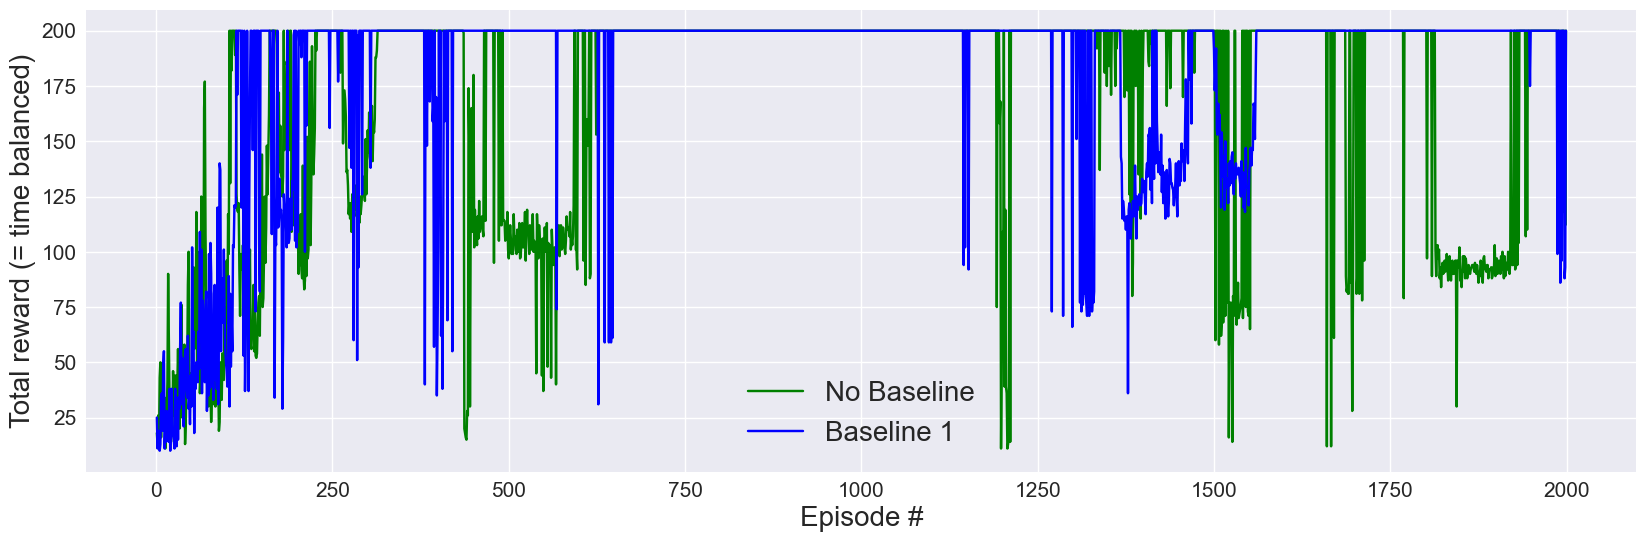

In [21]:
### Plot the learning progress

# Create the plot
fig = plt.figure(figsize=(20, 6))
ax = fig.add_subplot(111)

# Plot the scores with specified colors and labels
ax.plot(np.arange(1, len(scores_rwd2go) + 1), scores_rwd2go, color='green', label='No Baseline')

ax.plot(np.arange(1, len(scores_baseline_1) + 1), scores_baseline_1, color='blue', label='Baseline 1')

#ax.plot(np.arange(1, len(scores_baseline_2) + 1), scores_baseline_2, color='red', label='Baseline 2')

# Set the labels with a larger font size
ax.set_ylabel('Total reward (= time balanced)', fontsize=20)
ax.set_xlabel('Episode #', fontsize=20)

# Set the tick labels to a larger font size
ax.tick_params(axis='both', which='major', labelsize=15)

# Add a legend with a specified font size
ax.legend(fontsize=20)

# Show the plot
plt.show()

# $Q^\star$: Policy Gradient with continuous actions and bound on the bonuses count in OPPO (20 points)
***Question 1:*** Consider using a Gaussian parameterized policy $\pi_{\mu,\Sigma}$ with mean $\mu \in \mathrm{R}^d$ 
and covariance matrix $\Sigma$ . Write down the following gradients:

$$ \nabla_\mu J(\pi_{\mu, \Sigma}) = \sum_{\bar{s},\bar{a}} \lambda^{\pi_{\mu, \Sigma}}(\bar{s}, \bar{a}) Q^{\pi_{\mu, \Sigma}}(\bar{s}, \bar{a}) \frac{\bar{a} - \mu(\bar{s})}{\sigma^2(\bar{s})} $$
$$ \nabla_\Sigma J(\pi_{\mu, \Sigma}) = \sum_{\bar{s},\bar{a}} \lambda^{\pi_{\mu, \Sigma}}(\bar{s}, \bar{a}) Q^{\pi_{\mu, \Sigma}}(\bar{s}, \bar{a})
( \frac{(\bar{a} - \mu(\bar{s}))^2}{\sigma^3(\bar{s})} - \frac{1}{\sigma(\bar{s})})$$
***Question 2*** In this exercise, you will bound the state action counts. This is a crucial part of the OPPO convergence proof. Let $N^t_h(s,a)$ denotes the number of times the state action pair $s,a$ has been visited at step $h$ in all the episode up to $t$ included. Moreover,
let $s^t_h,a^t_h$ be the state action pair visited at step $h$ of the $t^{th}$ episode. Then, prove that 
$$ \sum^T_{t=1} \sum^H_{h=1} \frac{1}{N^t_h(s^t_h, a^t_h)+1} \leq SA \log( T H)$$


<font color = "blue">

Let $N(s,a)$ denotes the total number of visits of the state action pair among all episodes: $N(s,a) = \sum_{h = 1}^H N_h^T(s,a)$. Using this, we can rewrite the sum as a sum over all state-action pairs:

$$
\sum^T_{t=1} \sum^H_{h=1} \frac{1}{N^t_h(s^t_h, a^t_h)+1} = \sum_{(s, a)} \sum_{n = 1}^{N(s,a)} \frac{1}{n + 1} \le \sum_{(s, a)} \sum_{n = 1}^{N(s,a)} \frac{1}{n}
$$

We can then use the harmonic sum inequality:
$$
\sum^T_{t=1} \sum^H_{h=1} \frac{1}{N^t_h(s^t_h, a^t_h)+1} \le \sum_{(s, a)} \sum_{n = 1}^{N(s,a)} \frac{1}{n} \le \sum_{(s, a)} \log(N(s, a)) + 1 \le \sum_{(s, a)} \log(TH) + 1 = \vert \mathcal{S} \vert \vert \mathcal{A} \vert \log(TH) +  \vert \mathcal{S} \vert \vert \mathcal{A} \vert
$$

Where the last inequality comes from the fact that the algorithm visits each state action pair at most $TH$ times. In conclusion, we have

$$
\sum^T_{t=1} \sum^H_{h=1} \frac{1}{N^t_h(s^t_h, a^t_h)+1} \le \vert \mathcal{S} \vert \vert \mathcal{A} \vert (1 + \log(TH)) \approx \vert \mathcal{S} \vert \vert \mathcal{A} \vert \log(TH)
$$

The approximation holds when $T$ and $H$ are large.


***Question 3*** Use the fact above to prove the following bound at slide 30 of Lecture 5. That is, for $\mathrm{bonus}^t_h(s,a) = \frac{H}{\sqrt{N^t_h(s,a)}}$ it holds that
$$ \sum^T_{t=1} \sum^H_{h=1} \mathrm{bonus}(s^t_h, a^t_h) \leq \sqrt{ H^3 SA T \log( T H)}$$

<font color = "blue">

By applying Cauchy-Schwarz on the double sum, we get

$$
\sum^T_{t=1} \sum^H_{h=1} \mathrm{bonus}(s^t_h, a^t_h) = H \sum^T_{t=1} \sum^H_{h=1} \frac{1}{\sqrt{N_h^t(s,a)}} \le H \sqrt{TH} \sqrt{\sum^T_{t=1} \sum^H_{h=1} \frac{1}{N_h^t(s,a)}}
$$

Finally, we apply the bound proved above:

$$
\sum^T_{t=1} \sum^H_{h=1} \mathrm{bonus}(s^t_h, a^t_h) \le H \sqrt{TH} \sqrt{SA \log( T H)} = \sqrt{ H^3 SA T \log( T H)}
$$